In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.cluster.vq import kmeans, vq
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

K means clustering on tiles taken from an image

(480, 640)


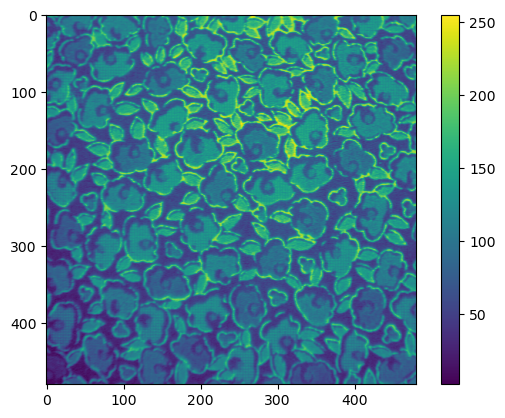

In [2]:
image_number = 10
# dimensionality (N) of subspace = 64
tile_w = 8
 

image = cv2.imread(f"Dataset/Image{image_number}.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
mindim = np.min(image.shape)
image = image[:mindim, :mindim]

plt.imshow(image)
plt.colorbar()
plt.show();

In [3]:
def return_tiles(image, tile_width):
    """
    image: A 2D array
    tile_width: the width of a square tile
    """
    width, height = image.shape

    # Calculate the number of tiles in each dimension
    num_tiles_x = width // tile_width
    num_tiles_y = height // tile_width

    # Initialize an empty array to store tiles
    # Reshape the image into tiles
    tiles = image[:num_tiles_y * tile_width, :num_tiles_x * tile_width].reshape(
        num_tiles_y, tile_width, num_tiles_x, tile_width)

    # Transpose the axes to get the desired shape
    tiles2d = tiles.transpose(0, 2, 1, 3).reshape(num_tiles_y, num_tiles_x, tile_width, tile_width)
    tiles1d = tiles2d.reshape(num_tiles_y*num_tiles_x, tile_width*tile_width)

    return tiles2d, tiles1d

In [4]:
# The data vector
im_tiles2d, im_tiles1d = return_tiles(image, tile_w)
print(im_tiles2d.shape)
print(im_tiles1d.shape)

(60, 60, 8, 8)
(3600, 64)


In [5]:
def visualize_tiles(tiles_array):
    num_tiles_y, num_tiles_x, tile_width, _ = tiles_array.shape

    #subplot with a grid of tiles
    fig, axes = plt.subplots(num_tiles_y, num_tiles_x, figsize=(10, 10))

    # Iterate through each tile and display
    for i in range(num_tiles_y):
        for j in range(num_tiles_x):
            axes[i, j].imshow(tiles_array[i, j, :, :])
            axes[i, j].axis('off')  # Turn off axis labels

    plt.show()

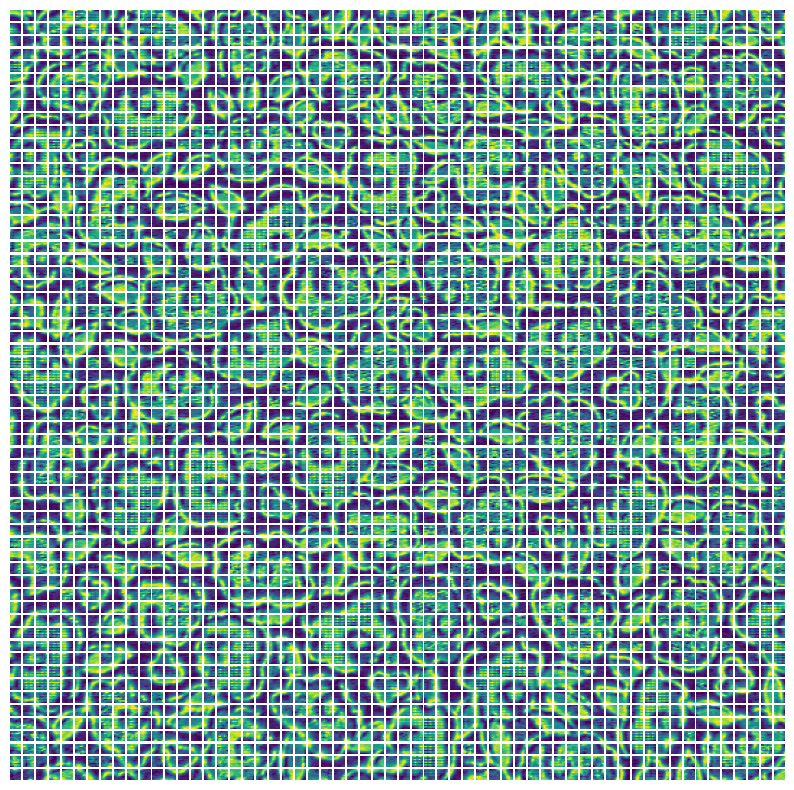

In [6]:
visualize_tiles(im_tiles2d)

In [7]:
im_tiles1d = im_tiles1d.astype(float)

### Decide the number of clusters
* And if needed, change the num_clusters argument in the start 

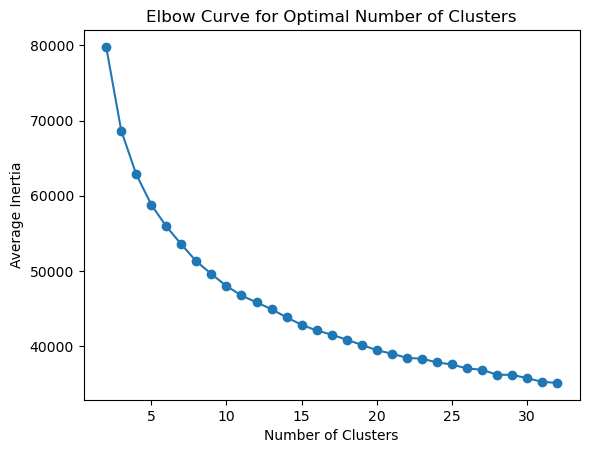

[79788.67667828541,
 68663.56566865557,
 62844.377912426324,
 58806.60377094273,
 55916.60756426123,
 53533.78239817803,
 51268.9669435226,
 49594.95502299823,
 47988.40134470503,
 46736.29917915471,
 45815.183629984815,
 44918.624701422574,
 43819.76908810033,
 42844.19694688546,
 42076.89147877633,
 41530.28977087184,
 40850.88049176588,
 40171.76032024513,
 39453.52643642053,
 39001.351717821286,
 38436.671592001236,
 38327.56317481545,
 37841.54035899762,
 37557.64424305263,
 37027.63495327472,
 36860.640790490026,
 36190.77266901866,
 36183.064981347525,
 35743.617990494604,
 35253.18260523607,
 35105.23315400214]

In [8]:
def calculate_inertia(data, centroids, cluster_indices):
    # Calculate within-cluster sum of squared distances
    # print(type(cluster_indices), cluster_indices.shape)
    distances = np.sum((data - centroids[cluster_indices]) ** 2)
    inertia = distances / len(data)
    return inertia

def elbow_method(data, max_clusters=32):
    inertias = []

    for num_clusters in range(2, max_clusters + 1):
        centroids, distortion = kmeans(data, num_clusters)
        cluster_indices, _ = vq(data, centroids)
        inertia = calculate_inertia(data, centroids, cluster_indices)
        inertias.append(inertia)

    plt.plot(range(2, max_clusters + 1), inertias, marker='o')
    plt.title('Elbow Curve for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Average Inertia')
    plt.show()

    return inertias

elbow_method(im_tiles1d, 32)

In [9]:
num_clusters = 20 

In [11]:
# Perform K-means clustering
# Adjust the number of clusters as needed
centroids, _ = kmeans(im_tiles1d, num_clusters)
print('data dimensions:', im_tiles1d.shape)
print('number of clusters:', num_clusters)
print('centroids shape:', centroids.shape)

#vector quatization
cluster_indices, _ = vq(im_tiles1d, centroids)
print('cluster_indices shape:', cluster_indices.shape)

# # Visualise the clusters using PCA
# pca = PCA(n_components=2)
# im_tiles1d_reduced = pca.fit_transform(im_tiles1d)

# # Visualize the clustering in a 2D plot
# plt.scatter(im_tiles1d_reduced[:, 0], im_tiles1d_reduced[:, 1], c=cluster_indices, cmap='viridis', alpha=0.8)
# plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Cluster Centroids')
# plt.title('K-means Clustering with PCA Dimensionality Reduction')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.legend()
# plt.show()

data dimensions: (3600, 64)
number of clusters: 20
centroids shape: (20, 64)
cluster_indices shape: (3600,)


Arranging clusters, means and medoids

In [28]:
def calculate_medoid(cluster):
    """
    cluster: an mxN array of m vectors in a cluster
    """
    # Pairwise distances between points in the cluster
    distances = cdist(cluster, cluster, metric='euclidean')
    total_distances = np.sum(distances, axis=1)
    medoid_index = np.argmin(total_distances)

    # Medoid is the data point with the minimum total distance
    medoid = cluster[medoid_index]

    return medoid

def get_cluster_medoids(data, cluster_indices):
    """
    Inputs:
    data: an mxN array of m data vectors (points)
    cluster_indices: an mx1 array of m cluster indices

    Returns:
    clusters: a dictionary, indexed by cluster number and values are clustered arrays of data
    mediods: a dictionary, indexed by cluster number and values are the medoid data vector
    means: a dictionary, '' '' values are means
    
    """
    unique_clusters = np.unique(cluster_indices)

    # Initialise a dictionary to store clusters
    clusters = {cluster: [] for cluster in unique_clusters}

    # Populate clusters dictionary with data points
    for i, cluster_index in enumerate(cluster_indices):
        clusters[cluster_index].append(data[i])

    # Calculate medoid for each cluster
    medoids = {cluster: calculate_medoid(np.array(points)) for cluster, points in clusters.items()}
    means = {cluster: np.mean(np.array(points), axis=0) for cluster, points in clusters.items()}

    return clusters, medoids, means

Centred Clusters

In [29]:
clustered_data, cluster_medoids, cluster_means = get_cluster_medoids(im_tiles1d, cluster_indices)
print ('keys of clustered data' ,clustered_data.keys())
print ('cluster means[0] has shape' , cluster_means[0].shape)
print ('clustered data[0] has shape' ,np.array(clustered_data[0]).shape)

def get_centered_clusters(clustered_data, cluster_means):
    centered_clusters = {cluster: (np.array(clustered_data[cluster])-cluster_means[cluster]) for cluster in clustered_data.keys()}
    return centered_clusters

centered_clusters = get_centered_clusters(clustered_data, cluster_means)

keys of clustered data dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
cluster means[0] has shape (64,)
clustered data[0] has shape (122, 64)


In [30]:
#check for mean zero--> checked
summa = 0
for i in range(num_clusters):
    summa += centered_clusters[i].sum()
print (summa)

5.5649707064731047e-11


In [31]:
def pca_for_cluster(cluster):
    """ 
    Inputs:
    cluster- mxN centered array of vectors from a single cluster

    Returns:
    cluster_pca
    """
    assert isinstance(cluster, np.ndarray)

    pca = PCA()
    cluster_pca = pca.fit_transform(cluster)
    pca_vectors = pca.components_
    # print('pca vectors shape:', pca_vectors.shape)


    #padding to make the cumsum array have data_dim(8x8=64) length
    data_dim = cluster.shape[-1] 
    padding_size = max(0, data_dim - len(pca.explained_variance_ratio_))
    expl_var_ratio_cumul = np.cumsum(np.pad(pca.explained_variance_ratio_, (0, padding_size), 'constant', constant_values=0))

    return cluster_pca, expl_var_ratio_cumul, pca_vectors

#test pca function
cluster_pca, expln_var_cum, pca_vectors = pca_for_cluster(centered_clusters[0])
print(type(cluster_pca), cluster_pca.shape)
print(pca_vectors.shape)


<class 'numpy.ndarray'> (122, 64)
(64, 64)


Cluster 0 dynamic_basis vectors shape: (10, 64)
Cluster compression when pruning 0.90 variance is 0.0820
--------------------
Cluster 1 dynamic_basis vectors shape: (11, 64)
Cluster compression when pruning 0.90 variance is 0.1310
--------------------
Cluster 2 dynamic_basis vectors shape: (8, 64)
Cluster compression when pruning 0.90 variance is 0.0494
--------------------
Cluster 3 dynamic_basis vectors shape: (12, 64)
Cluster compression when pruning 0.90 variance is 0.0992
--------------------
Cluster 4 dynamic_basis vectors shape: (11, 64)
Cluster compression when pruning 0.90 variance is 0.0948
--------------------
Cluster 5 dynamic_basis vectors shape: (10, 64)
Cluster compression when pruning 0.90 variance is 0.0763
--------------------
Cluster 6 dynamic_basis vectors shape: (9, 64)
Cluster compression when pruning 0.90 variance is 0.0818
--------------------
Cluster 7 dynamic_basis vectors shape: (15, 64)
Cluster compression when pruning 0.90 variance is 0.0598
---------------

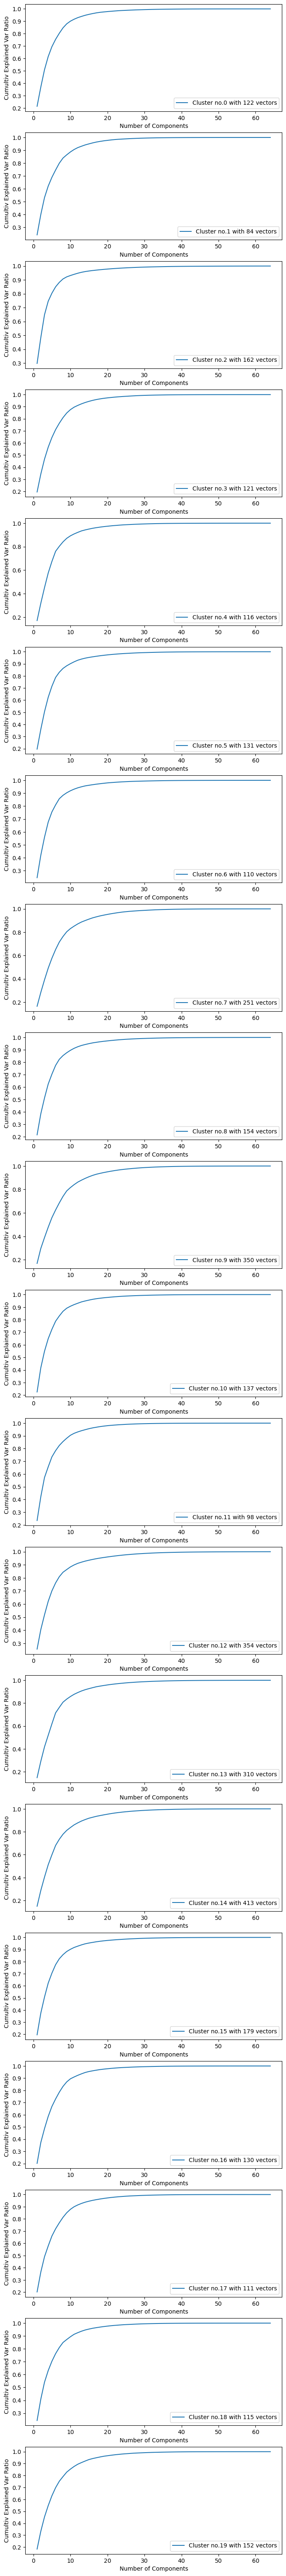

In [33]:
num_clusters = len(centered_clusters)
fig, axs = plt.subplots(nrows= num_clusters, ncols =1, figsize=(8,4* num_clusters))

#clusters_pcavectors and mean- a set basis(psi), one for each cluster
t_exp = 0.9
dynamic_psi = dict()
fixed_psi = dict()
dim_comp = 0.5
fixed_cut = int(dim_comp* np.square(tile_w))

for i, (cluster_key, points) in enumerate(centered_clusters.items()):
    cluster_pca, expln_var_cum, pca_vectors = pca_for_cluster(points)

    # find the index that reaches 0.9 cumsum variability
    cutidx = np.argmax(expln_var_cum >= t_exp)
    dynamic_basis = np.vstack((np.array([cluster_means[cluster_key]]), pca_vectors[:cutidx]))
    fixed_basis = np.vstack((np.array([cluster_means[cluster_key]]), pca_vectors[:fixed_cut]))

    # Add the dynamic_basis vectors describing the 0.9 variance
    dynamic_psi[cluster_key] = dynamic_basis

    # Add the fixed_basis vectors which are the 50% of the the basis vectors
    fixed_psi[cluster_key] = fixed_basis

    print('Cluster %d dynamic_basis vectors shape:'%(cluster_key), dynamic_basis.shape)
    print('Cluster compression when pruning %.2f variance is %.4f'%(t_exp, dynamic_basis.shape[0]/points.shape[0]))
    print('--------------------')
                      
    axs[i].plot(range(1, len(expln_var_cum) + 1), expln_var_cum, label='Cluster no.%d with %d vectors'%(cluster_key, points.shape[0]))
    axs[i].set_xlabel('Number of Components')
    axs[i].set_ylabel('Cumultiv Explained Var Ratio')
    axs[i].legend()

# plt.savefig('results/Patching_Image_%d.pdf'%(image_number))
plt.show()

In [40]:
# Approximate x_hat = Psi_k alpha; for each tile x_hat
def fit_to_basis(data_vectors, basis_vectors):
    """ 
    basis_vectors : an mxN array with a basis vector(N-dimensional) in each row 
    data_vectors : an nxN array with n examples of (N-dimensional) data.
    """ 
    projection_matrix = basis_vectors.T @ (np.linalg.pinv(basis_vectors @ basis_vectors.T) @ basis_vectors)
    approximations = data_vectors @ projection_matrix
    errors = np.linalg.norm(data_vectors - approximations , axis=1)
    # print(errors.shape)
    return approximations, errors

 cluster 0 has error after fitting: 
 dynamic basis selection: 72.2240 
 fixed top 0.50: 13.9128 
 ------ 
 cluster 1 has error after fitting: 
 dynamic basis selection: 92.6947 
 fixed top 0.50: 16.4650 
 ------ 
 cluster 2 has error after fitting: 
 dynamic basis selection: 40.9421 
 fixed top 0.50: 10.0410 
 ------ 
 cluster 3 has error after fitting: 
 dynamic basis selection: 81.9764 
 fixed top 0.50: 17.7040 
 ------ 
 cluster 4 has error after fitting: 
 dynamic basis selection: 64.8340 
 fixed top 0.50: 13.8464 
 ------ 
 cluster 5 has error after fitting: 
 dynamic basis selection: 66.1644 
 fixed top 0.50: 14.3595 
 ------ 
 cluster 6 has error after fitting: 
 dynamic basis selection: 54.0659 
 fixed top 0.50: 11.2025 
 ------ 
 cluster 7 has error after fitting: 
 dynamic basis selection: 59.3276 
 fixed top 0.50: 18.6083 
 ------ 
 cluster 8 has error after fitting: 
 dynamic basis selection: 50.6165 
 fixed top 0.50: 12.4534 
 ------ 
 cluster 9 has error after fitting: 


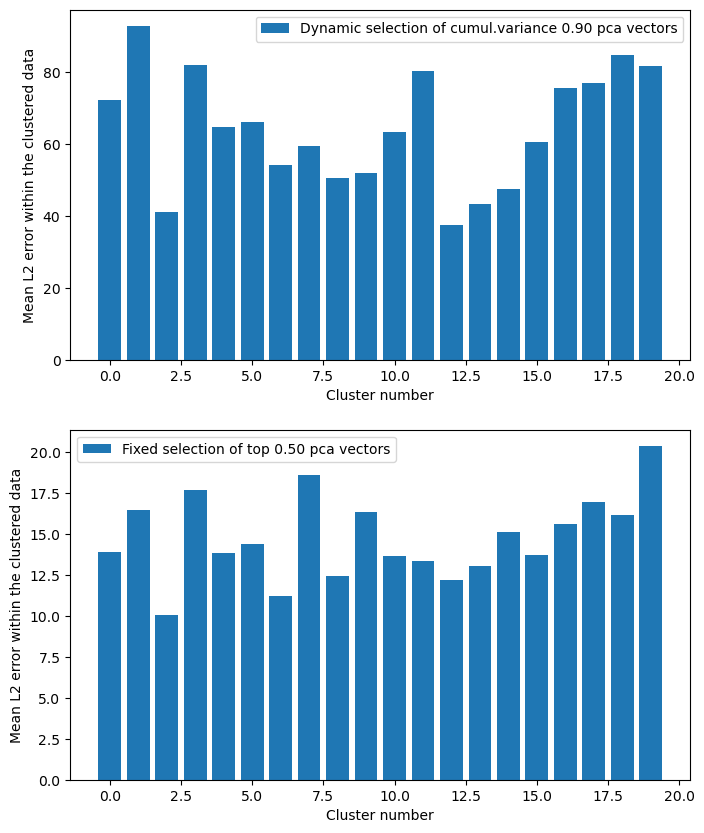

In [54]:
dyn_errors = []
fix_errors = []
for i, (cluster_key, points) in enumerate(clustered_data.items()):
    dyn_approx, dyn_errs = fit_to_basis(clustered_data[cluster_key], dynamic_psi[cluster_key])
    fix_approx, fix_errs = fit_to_basis(clustered_data[cluster_key], fixed_psi[cluster_key])
    dyn_errors.append(np.mean(dyn_errs))
    fix_errors.append(np.mean(fix_errs))
    print(" cluster %d has error after fitting: \n dynamic basis selection: %.4f \n fixed top %.2f: %.4f \n ------ "%(i, np.mean(dyn_errs), dim_comp, np.mean(fix_errs)))

# print(np.array(dyn_errors).shape)

fig, axs = plt.subplots(nrows= 2, ncols =1, figsize=(8,10))
axs[0].bar(np.array(range(num_clusters)), dyn_errors, label='Dynamic selection of cumul.variance %.2f pca vectors'%(t_exp))
axs[0].set_xlabel('Cluster number')
axs[0].set_ylabel('Mean L2 error within the clustered data')
axs[0].legend()

axs[1].bar(range(num_clusters), fix_errors, label='Fixed selection of top %.2f pca vectors'%(dim_comp))
axs[1].set_xlabel('Cluster number')
axs[1].set_ylabel('Mean L2 error within the clustered data')
axs[1].legend()